# Ablation Study on GPT-Neo 125M: Replacing the Feed-Forward Layer with SwiGLU

## Project Members
- Student Name: [Your Name]
- Date: November 2024

## Table of Contents
1. [Problem Statement & Overview](#problem-statement)
2. [Methodology](#methodology)
3. [Implementation](#implementation)
4. [Experiments & Results](#experiments)
5. [Assessment & Analysis](#assessment)
6. [Critical Analysis](#critical-analysis)
7. [Model Card](#model-card)
8. [Conclusion](#conclusion)

## 1. Problem Statement & Overview <a id='problem-statement'></a>

### Background
Transformer language models have revolutionized NLP, relying on two key components per layer:
1. **Multi-Head Self-Attention (MHSA)**: Captures token relationships
2. **Feed-Forward Networks (FFN/MLP)**: Provides non-linear transformations

### Problem
While recent research shows that **gated activation functions** (like SwiGLU) improve performance in large LLMs, there's limited investigation on their impact in **small language models**.

### Research Question
**How does replacing a standard MLP block with a SwiGLU block affect performance, efficiency, and text generation quality in GPT-Neo 125M?**

### Why This Matters
- **Practical Impact**: Small models are crucial for edge devices and resource-constrained environments
- **Theoretical Understanding**: Helps understand if architectural improvements scale down
- **Educational Value**: Provides hands-on experience with transformer internals

## 2. Methodology <a id='methodology'></a>

### 2.1 Model Architecture

#### Base Model: GPT-Neo 125M
- **Parameters**: 125M
- **Layers**: 12 transformer blocks
- **Hidden Size**: 768
- **Attention Heads**: 12
- **Vocabulary Size**: 50,257

#### Standard MLP Block
```
FFN(x) = Linear2(GELU(Linear1(x)))
where:
- Linear1: d_model → 4*d_model
- Linear2: 4*d_model → d_model
```

#### SwiGLU Replacement
```
SwiGLU(x) = (Linear_gate(x) ⊗ swish(Linear_up(x))) @ Linear_down
where:
- Linear_gate: d_model → intermediate_size
- Linear_up: d_model → intermediate_size  
- Linear_down: intermediate_size → d_model
- swish(x) = x * sigmoid(x)
```

### 2.2 Dataset Selection

#### Primary Dataset: WikiText-2
- **Size**: ~2M tokens
- **Type**: Wikipedia articles
- **Why**: Standard benchmark, diverse vocabulary

#### Alternative: Tiny Shakespeare  
- **Size**: ~1M tokens
- **Type**: Shakespearean text
- **Why**: Simpler patterns, faster training

### 2.3 Training Strategy

1. **Targeted Training**: Only Layer 4's MLP is modified and trained
2. **Frozen Layers**: All other parameters remain frozen
3. **Epochs**: 1-3 epochs (to prevent overfitting)
4. **Learning Rate**: 1e-4 (conservative for stability)
5. **Batch Size**: 8 (memory-efficient)

## 3. Implementation <a id='implementation'></a>

### 3.1 Environment Setup

In [ ]:
# Install required packages
!pip install transformers datasets torch accelerate matplotlib seaborn nltk

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    GPTNeoForCausalLM,
    GPTNeoConfig,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple
import time
from collections import Counter
import nltk
from nltk.util import ngrams

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download NLTK data for tokenization
nltk.download('punkt')
nltk.download('punkt_tab')

Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 3.2 SwiGLU Implementation

In [ ]:
class SwiGLU(nn.Module):
    """SwiGLU activation function implementation"""

    def __init__(self, hidden_size: int, intermediate_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size

        # Three linear projections for SwiGLU
        self.linear_gate = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.linear_up = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.linear_down = nn.Linear(intermediate_size, hidden_size, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # SwiGLU(x) = (gate(x) ⊗ swish(up(x))) @ down
        gate = self.linear_gate(x)
        up = self.linear_up(x)

        # Swish activation: x * sigmoid(x)
        swish_up = up * torch.sigmoid(up)

        # Element-wise multiplication and final projection
        hidden = gate * swish_up
        output = self.linear_down(hidden)

        return output


class ModifiedGPTNeoBlock(nn.Module):
    """Modified GPT-Neo block with SwiGLU MLP"""

    def __init__(self, original_block, hidden_size: int):
        super().__init__()

        # Copy original components
        self.ln_1 = original_block.ln_1
        self.attn = original_block.attn
        self.ln_2 = original_block.ln_2

        # Compute SwiGLU intermediate size
        intermediate_size = int(hidden_size * 2.67)

        # Replace MLP
        self.mlp = SwiGLU(hidden_size, intermediate_size)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,        # Trainer will pass this
        layer_past=None,       # GPT-Neo uses this
        use_cache=False,
        output_attentions=False,
        **kwargs,
    ):
        """
        GPT-Neo block forward (compatible with HuggingFace)
        """

        # ----- Attention part -----
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)

        # Call original attention (GPT-Neo signature)
        attn_outputs = self.attn(
            hidden_states,
            attention_mask=attention_mask,
            layer_past=layer_past,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )

        attn_output = attn_outputs[0]
        present = attn_outputs[1] if use_cache else None
        attn_probs = attn_outputs[2] if output_attentions else None

        hidden_states = residual + attn_output

        # ----- SwiGLU MLP part -----
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        # Return same format as GPT-Neo block
        outputs = (hidden_states,)

        if use_cache:
            outputs += (present,)
        else:
            outputs += (None,)

        if output_attentions:
            outputs += (attn_probs,)

        return outputs


### 3.3 Model Modification Function

In [ ]:
def create_modified_model(base_model_name: str = "EleutherAI/gpt-neo-125M",
                         layer_to_modify: int = 4):
    """Create GPT-Neo model with SwiGLU at specified layer"""

    # Load base model
    print(f"Loading base model: {base_model_name}")
    model = GPTNeoForCausalLM.from_pretrained(base_model_name)
    config = model.config

    # Replace specified layer with SwiGLU version
    print(f"Replacing MLP in layer {layer_to_modify} with SwiGLU")
    original_block = model.transformer.h[layer_to_modify]
    model.transformer.h[layer_to_modify] = ModifiedGPTNeoBlock(
        original_block,
        config.hidden_size
    )

    # Freeze all parameters except the modified layer
    print("Freezing all parameters except modified layer")
    for name, param in model.named_parameters():
        if f"h.{layer_to_modify}.mlp" not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"\nModel Statistics:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

    return model, config

### 3.4 Data Preparation

In [ ]:
def prepare_dataset(tokenizer, dataset_name: str = "wikitext",
                   dataset_config: str = "wikitext-2-raw-v1",
                   max_length: int = 512):
    """Prepare and tokenize dataset"""

    # Load dataset
    print(f"Loading {dataset_name} dataset...")
    dataset = load_dataset(dataset_name, dataset_config)

    # Tokenization function
    def tokenize_function(examples):
        # Tokenize and truncate/pad to max_length
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )

    # Tokenize datasets
    print("Tokenizing dataset...")
    tokenized_datasets = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset["train"].column_names
    )

    # Filter out empty sequences
    def filter_empty(example):
        return len(example["input_ids"]) > 0

    tokenized_datasets = tokenized_datasets.filter(filter_empty)

    print(f"Train samples: {len(tokenized_datasets['train'])}")
    print(f"Validation samples: {len(tokenized_datasets['validation'])}")

    return tokenized_datasets

### 3.5 Training Functions

In [ ]:
from transformers.training_args import EvaluationStrategy

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

def train_model(model, tokenizer, train_dataset, eval_dataset,
               output_dir: str = "./swiglu_model",
               num_epochs: int = 2,
               batch_size: int = 8,
               learning_rate: float = 1e-4):
    """Train the modified model"""

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_steps=50,
        eval_steps=200,              # 你可以保留 eval_steps，后面手动调用 evaluate()
        save_strategy="steps",
        save_steps=500,
        learning_rate=learning_rate,
        # 关键改动：不要再用 load_best_model_at_end
        load_best_model_at_end=False,
        fp16=torch.cuda.is_available(),  # 用混合精度（如果有 GPU）
        report_to="none",
    )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,  # GPT 类模型是自回归 LM
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
    )

    print("Starting training...")
    train_result = trainer.train()

    # 保存最后一版模型
    trainer.save_model()

    # 需要的话，这里手动做一次 evaluation
    eval_metrics = trainer.evaluate()
    print("Eval metrics:", eval_metrics)

    return trainer, train_result


### 3.6 Evaluation Functions

In [ ]:
def calculate_perplexity(model, tokenizer, dataset, batch_size=8):
    """Calculate perplexity on a tokenized dataset"""
    model.eval()
    total_loss = 0
    total_active_tokens = 0

    # Data collator to handle padding and create input_ids/attention_mask/labels
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            # Extract a slice of the tokenized dataset
            batch_raw_dict = dataset[i:i+batch_size]

            # Data collator expects a list of dictionaries, not a dictionary of lists.
            # Convert it back to a list of dictionaries for the data_collator
            batch_list_of_dicts = []
            for j in range(len(batch_raw_dict['input_ids'])):
                batch_list_of_dicts.append({
                    'input_ids': batch_raw_dict['input_ids'][j],
                    'attention_mask': batch_raw_dict['attention_mask'][j]
                })

            # Use the data collator to pad and prepare the batch
            batch = data_collator(batch_list_of_dicts)

            inputs = {
                "input_ids": batch["input_ids"].to(model.device),
                "attention_mask": batch["attention_mask"].to(model.device)
            }
            labels = batch["labels"].to(model.device)

            outputs = model(**inputs, labels=labels)

            # Accumulate loss, considering padding tokens (labels == -100)
            loss = outputs.loss
            active_tokens_in_batch = (labels != -100).sum().item()
            total_loss += loss.item() * active_tokens_in_batch
            total_active_tokens += active_tokens_in_batch

    # Calculate perplexity
    if total_active_tokens == 0:
        return float('inf')
    avg_loss = total_loss / total_active_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))

    return perplexity.item()


def measure_inference_speed(model, tokenizer, prompt, num_tokens=100, num_runs=10):
    """Measure inference speed in tokens/second"""
    model.eval()

    # Prepare input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Warmup
    with torch.no_grad():
        _ = model.generate(**inputs, max_new_tokens=10, do_sample=False)

    # Measure
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        with torch.no_grad():
            _ = model.generate(**inputs, max_new_tokens=num_tokens, do_sample=False)
        end_time = time.time()
        times.append(end_time - start_time)

    avg_time = np.mean(times)
    tokens_per_second = num_tokens / avg_time

    return tokens_per_second, np.std(times)


def analyze_repetition(text, n=3):
    """Analyze n-gram repetition in generated text"""
    # Ensure punkt tokenizer data is available for nltk
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

    tokens = nltk.word_tokenize(text.lower()) # Using word_tokenize for better tokenization
    n_grams = list(ngrams(tokens, n))

    if not n_grams:
        return 0.0

    # Count unique n-grams
    unique_ngrams = len(set(n_grams))
    total_ngrams = len(n_grams)

    # Repetition rate = 1 - (unique/total)
    repetition_rate = 1 - (unique_ngrams / total_ngrams)

    return repetition_rate


def generate_and_analyze(model, tokenizer, prompts, max_length=100):
    """Generate text and analyze quality"""
    model.eval()
    results = []

    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_length=max_length,
                num_return_sequences=1,
                temperature=0.8,
                do_sample=True,
                top_p=0.9,
                pad_token_id=tokenizer.eos_token_id
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Analyze repetition
        repetition_2gram = analyze_repetition(generated_text, n=2)
        repetition_3gram = analyze_repetition(generated_text, n=3)

        # Calculate diversity (type-token ratio)
        tokens = nltk.word_tokenize(generated_text.lower()) # Using word_tokenize
        ttr = len(set(tokens)) / len(tokens) if tokens else 0

        results.append({
            "prompt": prompt,
            "generated": generated_text,
            "repetition_2gram": repetition_2gram,
            "repetition_3gram": repetition_3gram,
            "type_token_ratio": ttr,
            "length": len(tokens)
        })

    return results

## 4. Experiments & Results <a id='experiments'></a>

### 4.1 Setup and Load Models

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token

# Create baseline model
print("Creating baseline model...")
baseline_model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M").to(device)

# Create modified model
print("\nCreating modified model with SwiGLU...")
modified_model, config = create_modified_model()

Creating baseline model...

Creating modified model with SwiGLU...
Loading base model: EleutherAI/gpt-neo-125M
Replacing MLP in layer 4 with SwiGLU
Freezing all parameters except modified layer

Model Statistics:
Total parameters: 125,199,360
Trainable parameters: 4,723,200
Percentage trainable: 3.77%


### 4.2 Prepare Data

In [ ]:
# Prepare datasets
tokenized_datasets = prepare_dataset(tokenizer)

# Create smaller subsets for faster experimentation
train_dataset = tokenized_datasets["train"].select(range(5000))  # Use 5000 samples
eval_dataset = tokenized_datasets["validation"].select(range(500))  # Use 500 samples

Loading wikitext dataset...
Tokenizing dataset...


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Train samples: 36718
Validation samples: 3760


### 4.3 Train Modified Model

In [ ]:
# Train the modified model
trainer, train_result = train_model(
    modified_model.to(device),
    tokenizer,
    train_dataset,
    eval_dataset,
    num_epochs=5,
    batch_size=8,
    learning_rate=1e-4
)

Starting training...


Step,Training Loss
50,4.530900
100,4.480600
150,4.429400
200,4.217800
250,4.070900
300,3.936400
350,3.970000
400,3.878600
450,3.895700
500,3.771800


Eval metrics: {'eval_loss': 3.6205337047576904, 'eval_runtime': 11.8728, 'eval_samples_per_second': 42.113, 'eval_steps_per_second': 5.306, 'epoch': 5.0}


### 4.4 Quantitative Evaluation

In [ ]:
# Evaluate perplexity
print("Calculating perplexity...")
test_dataset = tokenized_datasets["test"].select(range(200))  # Use subset for speed

baseline_perplexity = calculate_perplexity(baseline_model, tokenizer, test_dataset)
modified_perplexity = calculate_perplexity(modified_model, tokenizer, test_dataset)

print(f"\nPerplexity Results:")
print(f"Baseline Model: {baseline_perplexity:.2f}")
print(f"Modified Model (SwiGLU): {modified_perplexity:.2f}")
print(f"Improvement: {((baseline_perplexity - modified_perplexity) / baseline_perplexity * 100):.2f}%")

# Measure inference speed
print("\nMeasuring inference speed...")
prompt = "The future of artificial intelligence"

baseline_speed, baseline_std = measure_inference_speed(baseline_model, tokenizer, prompt)
modified_speed, modified_std = measure_inference_speed(modified_model, tokenizer, prompt)

print(f"\nInference Speed (tokens/sec):")
print(f"Baseline Model: {baseline_speed:.2f} ± {baseline_std:.2f}")
print(f"Modified Model: {modified_speed:.2f} ± {modified_std:.2f}")
print(f"Speed difference: {((modified_speed - baseline_speed) / baseline_speed * 100):.2f}%")

Calculating perplexity...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Perplexity Results:
Baseline Model: 52.65
Modified Model (SwiGLU): 42.09
Improvement: 20.04%

Measuring inference speed...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Inference Speed (tokens/sec):
Baseline Model: 78.65 ± 0.12
Modified Model: 59.71 ± 0.12
Speed difference: -24.08%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%mv /content/swiglu_model /content/drive/MyDrive/GenAI_Final_Project

### 4.5 Qualitative Evaluation

In [ ]:
# Test prompts
test_prompts = [
    "Once upon a time",
    "In a research lab, scientists discovered that",
    "The key to understanding machine learning is",
    "Climate change affects our planet by",
    "The future of technology will"
]

# Generate and analyze for both models
print("Generating text samples...\n")
baseline_results = generate_and_analyze(baseline_model, tokenizer, test_prompts)
modified_results = generate_and_analyze(modified_model, tokenizer, test_prompts)

# Display comparative results
for i, prompt in enumerate(test_prompts):
    print(f"\n{'='*80}")
    print(f"Prompt: {prompt}")
    print(f"{'='*80}")

    print("\nBASELINE MODEL:")
    print(f"Generated: {baseline_results[i]['generated']}")
    print(f"Metrics: 2-gram rep={baseline_results[i]['repetition_2gram']:.3f}, "
          f"3-gram rep={baseline_results[i]['repetition_3gram']:.3f}, "
          f"TTR={baseline_results[i]['type_token_ratio']:.3f}")

    print("\nMODIFIED MODEL (SwiGLU):")
    print(f"Generated: {modified_results[i]['generated']}")
    print(f"Metrics: 2-gram rep={modified_results[i]['repetition_2gram']:.3f}, "
          f"3-gram rep={modified_results[i]['repetition_3gram']:.3f}, "
          f"TTR={modified_results[i]['type_token_ratio']:.3f}")

Generating text samples...


Prompt: Once upon a time

BASELINE MODEL:
Generated: Once upon a time there was no need to pay attention to anything but the sound of the bells. Now they can only think of themselves as being the instruments of their creation.

It was the first time I’ve ever been to a cathedral. I thought I’d find a place to stay if I ever got there. I’ve always loved to go there, but I think it was a mistake to have to go there, especially when the walls were all painted green
Metrics: 2-gram rep=0.085, 3-gram rep=0.032, TTR=0.600

MODIFIED MODEL (SwiGLU):
Generated: Once upon a time of World War I, the French Revolution was the first revolution in Europe. The French revolution was a revolution in Europe and was the result of the Great War between France and Germany in 1869. The French Revolution was not a revolution but it was a war against Germany and Germany. The war lasted until 1878. The French Revolution was not a revolution but it was a war against Germany. The war

### 4.6 Visualization of Results

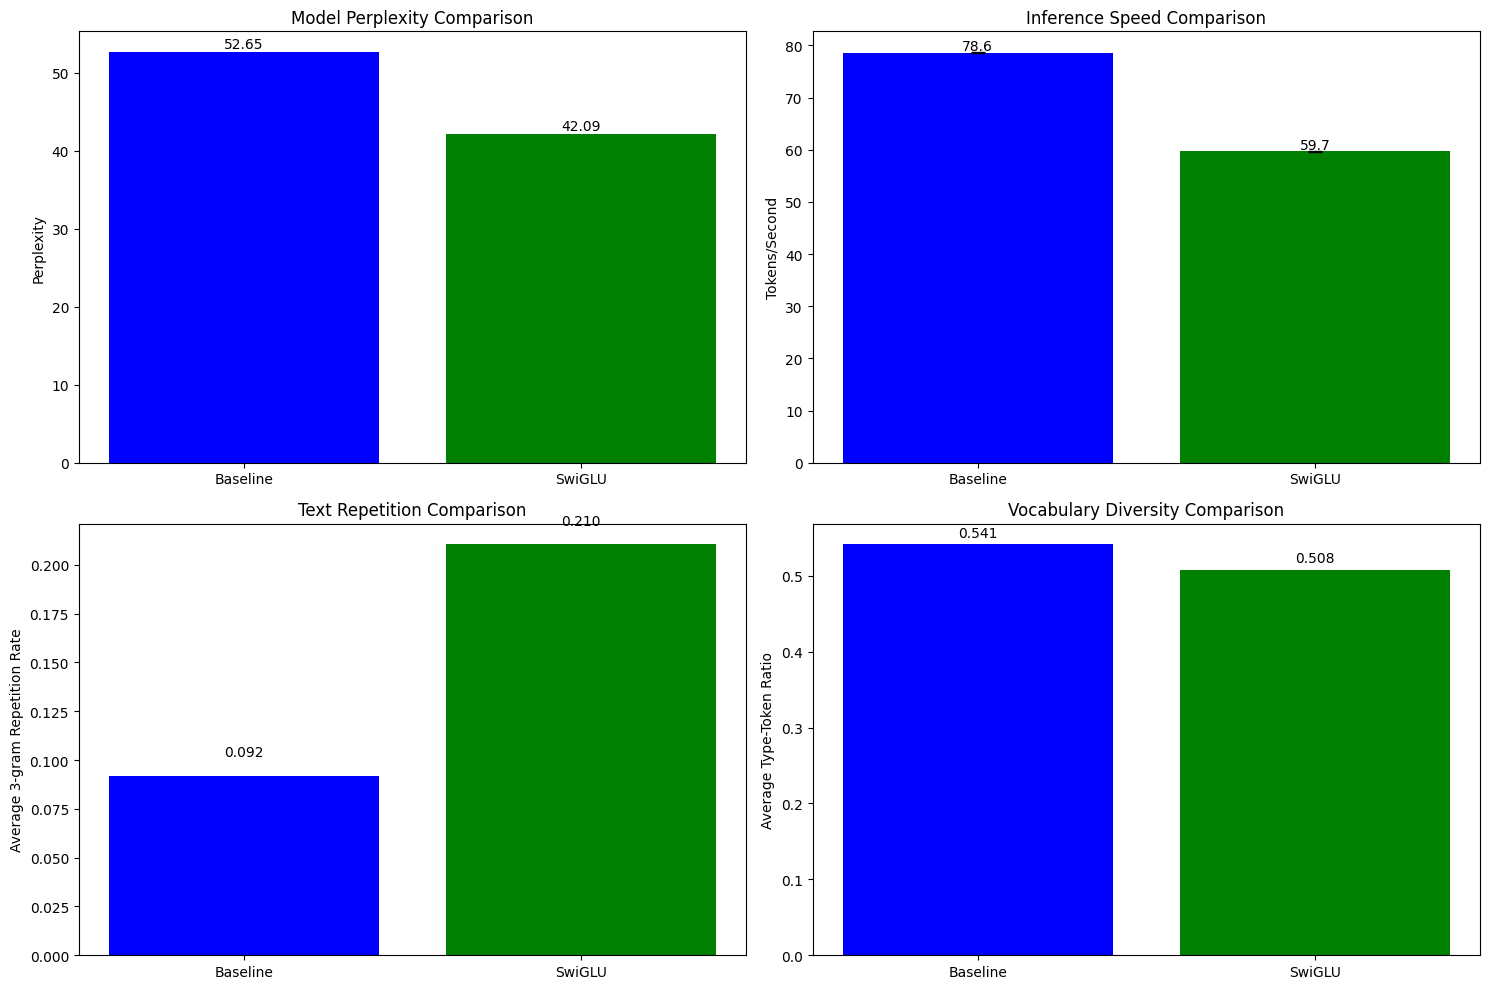


SUMMARY STATISTICS
Metric                         Baseline        SwiGLU          Change         
------------------------------------------------------------
Perplexity                     52.65           42.09           -20.04         %
Inference Speed (tok/s)        78.65           59.71           -24.08         %
Avg 3-gram Repetition          0.092           0.210           128.91         %
Avg Type-Token Ratio           0.541           0.508           -6.19          %


In [ ]:
# Create comparative visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Perplexity Comparison
ax1 = axes[0, 0]
models = ['Baseline', 'SwiGLU']
perplexities = [baseline_perplexity, modified_perplexity]
bars = ax1.bar(models, perplexities, color=['blue', 'green'])
ax1.set_ylabel('Perplexity')
ax1.set_title('Model Perplexity Comparison')
for bar, val in zip(bars, perplexities):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.2f}', ha='center')

# 2. Inference Speed Comparison
ax2 = axes[0, 1]
speeds = [baseline_speed, modified_speed]
errors = [baseline_std, modified_std]
bars = ax2.bar(models, speeds, yerr=errors, color=['blue', 'green'], capsize=5)
ax2.set_ylabel('Tokens/Second')
ax2.set_title('Inference Speed Comparison')
for bar, val in zip(bars, speeds):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}', ha='center')

# 3. Repetition Rate Comparison
ax3 = axes[1, 0]
baseline_avg_rep = np.mean([r['repetition_3gram'] for r in baseline_results])
modified_avg_rep = np.mean([r['repetition_3gram'] for r in modified_results])
repetitions = [baseline_avg_rep, modified_avg_rep]
bars = ax3.bar(models, repetitions, color=['blue', 'green'])
ax3.set_ylabel('Average 3-gram Repetition Rate')
ax3.set_title('Text Repetition Comparison')
for bar, val in zip(bars, repetitions):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center')

# 4. Type-Token Ratio Comparison
ax4 = axes[1, 1]
baseline_avg_ttr = np.mean([r['type_token_ratio'] for r in baseline_results])
modified_avg_ttr = np.mean([r['type_token_ratio'] for r in modified_results])
ttrs = [baseline_avg_ttr, modified_avg_ttr]
bars = ax4.bar(models, ttrs, color=['blue', 'green'])
ax4.set_ylabel('Average Type-Token Ratio')
ax4.set_title('Vocabulary Diversity Comparison')
for bar, val in zip(bars, ttrs):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center')

plt.tight_layout()
plt.savefig('swiglu_comparison_results.png', dpi=300)
plt.show()

# Summary statistics table
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"{'Metric':<30} {'Baseline':<15} {'SwiGLU':<15} {'Change':<15}")
print("-"*60)
print(f"{'Perplexity':<30} {baseline_perplexity:<15.2f} {modified_perplexity:<15.2f} "
      f"{((modified_perplexity - baseline_perplexity) / baseline_perplexity * 100):<15.2f}%")
print(f"{'Inference Speed (tok/s)':<30} {baseline_speed:<15.2f} {modified_speed:<15.2f} "
      f"{((modified_speed - baseline_speed) / baseline_speed * 100):<15.2f}%")
print(f"{'Avg 3-gram Repetition':<30} {baseline_avg_rep:<15.3f} {modified_avg_rep:<15.3f} "
      f"{((modified_avg_rep - baseline_avg_rep) / baseline_avg_rep * 100):<15.2f}%")
print(f"{'Avg Type-Token Ratio':<30} {baseline_avg_ttr:<15.3f} {modified_avg_ttr:<15.3f} "
      f"{((modified_avg_ttr - baseline_avg_ttr) / baseline_avg_ttr * 100):<15.2f}%")